## Images Visual Relationship project
This project is based on the [Google AI Open Images - Visual Relationship Track Kaggle Challenge](https://www.kaggle.com/c/google-ai-open-images-visual-relationship-track).

The challenge is to build the best performing algorithm for automatically detecting relationships triplets.

In [1]:
import argparse
import csv
import pickle
import os
import numpy as np
from PIL import Image
import cv2
import glob
from shutil import copyfile
import collections
from joblib import Parallel, delayed

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

import keras
from keras import __version__ as keras_version
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Lambda, Cropping2D, Reshape
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from keras import backend as K

import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline

import warnings
warnings.simplefilter('ignore', UserWarning)

/home/powell/ENTER/envs/carnd-term1/lib/python3.5/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Helper APIs

In [2]:
"""
Helper API
"""
def process_raw_csv_input(prefix='data/raw', train_csv_fname = 'challenge-2018-train-vrd.csv', 
                      labels_csv_fname_list = ['class-descriptions-boxable.csv', 'class-descriptions.csv']):
    """
    Process the labels from given label names and create three categories
    a. Entity
    b. Attribute
    c. Relationship
    """
    
    label_dict = {}
    # Process the labels info files and create a key value pair
    for flabel_csv in labels_csv_fname_list:
        with open(os.path.join(prefix, flabel_csv)) as f:
            rows = csv.reader(f)
            for row in rows:
                if row[0] in label_dict:
                    #print('Label already exists: {}:{}, new label: {}:{}'.
                    #       format(row[0], label_dict[row[0]], row[0], row[1]))
                    assert row[1] == label_dict[row[0]]
                label_dict[row[0]]=row[1]
    
    # Process the training data and create x, y i.e x->(imageid, (bounding box data)) y->(label1,label2,relationship)
    label1_dict = collections.defaultdict(int)
    label2_dict = collections.defaultdict(int)
    relationship_dict = collections.defaultdict(int)
    xy_list = []
    missing_label_dict = {}
    ignore_header = True
    miss_count = 0
    with open(os.path.join(prefix, train_csv_fname)) as f:
        rows = csv.reader(f)
        for row in rows:
            miss = False
            if ignore_header:
                ignore_header = False
                continue
            x = (row[0], (row[3:11]))
            y = (row[1], row[2], row[11])
            if y[0] not in label_dict:
                if y[0] not in missing_label_dict:
                    print('Label1 missing: {}'.format(y[0]))
                miss = True
                missing_label_dict[y[0]] = y[0]
            else:
                label1_dict[y[0]] += 1
            if y[1] not in label_dict:
                if y[1] not in missing_label_dict:
                    print('Label2 missing: {}, label1 : {}, relation: {}'.format(y[1], label_dict[y[0]], row[11]))
                miss_count += 1
                miss = True
                missing_label_dict[y[1]] = y[1]
            else:
                label2_dict[y[1]] += 1
            relationship_dict[y[2]] += 1
            if miss is False:
                xy_list.append((x, y))
    print ("Missing label count: {}".format(miss_count))             
    return xy_list, (label1_dict, label2_dict, relationship_dict), label_dict

def get_data_dir_from_raw_single_dir(X_dict, prefix='data', dir_list=None, out_dir='processed'):
    X_fset = set()
    copy_prefix_dir = os.path.join(prefix, out_dir)
    for d in dir_list:
        copy_dir = os.path.join(os.getcwd(), os.path.join(copy_prefix_dir, d))
        os.makedirs(copy_dir, exist_ok=True)
        flist = glob.glob(os.path.join(os.path.join(prefix, d), '*.jpg'))
        for f in flist:
            fid = os.path.basename(f).split('.')[0]
            if fid in X_dict:
                dst_f = os.path.join(copy_dir, os.path.basename(f))
                X_fset.add(dst_f)
                X_dict[fid] = (X_dict[fid], dst_f)
                copyfile(os.path.join(os.getcwd(), f), dst_f)
                
    return X_fset

def get_data_from_dir_recursive(X_dict, prefix='data/processed', dir_input='raw'):
    X_fset = set()
    X_valid_dict = {}
    def process_files(dir_path):
        flist = glob.glob(os.path.join(dir_path, '*.jpg'))
        print('Processing dir: {}, image count: {}'.format(dir_path, len(flist)))
            
        for f in flist:
            fid = os.path.basename(f).split('.')[0]
            if fid in X_dict:
                X_fset.add(f)
                X_valid_dict[fid] = (X_dict[fid][0], f)
                
    def helper(dir_input_full):
        l = next(os.walk(dir_input_full))[1]
        if len(l) == 0:   
            return
        
        for d in l:
            dir_path = os.path.join(dir_input_full, d)
            process_files(dir_path)
            helper(dir_path)
    
    process_files(os.path.join(prefix, dir_input))
    helper(os.path.join(prefix, dir_input))
    return X_fset, X_valid_dict

### RAW data gathering code
The following few cells look are helper code to get the available images and the labels from the larger vision image data.

Do not run it again. It has been run and resized data that is being used is available in
```
data/processed/resized_images
```

The RAW data is gathered from https://www.figure-eight.com/dataset/open-images-annotated-with-bounding-boxes/
Of the 1.5 Million or so images only around 100,000 match what is given in **challenge-2018-train-vrd.csv** from
https://www.kaggle.com/c/google-ai-open-images-visual-relationship-track/discussion/61919

In [3]:
xy_list, train_data_label_tuple, label_dict = process_raw_csv_input()

Label2 missing: /m/02gy9n, label1 : Bottle, relation: is
Missing label count: 20644


In [4]:
# Get the image id dict
X_dict = {}
for xy in xy_list:
    x = xy[0]
    X_dict[x[0]] = (xy, None)
    
## The folloowing is used to get data from "train_00.zip", "train_01.zip", .. "test.zip" etc.
#X_fset = get_data_dir(X_dict, dir_list=['raw/test'])

X_fset, X_valid_dict = get_data_from_dir_recursive(X_dict)
X_dict = X_valid_dict

Processing dir: data/processed/raw, image count: 0
Processing dir: data/processed/raw/train_01, image count: 11290
Processing dir: data/processed/raw/train_06, image count: 10789
Processing dir: data/processed/raw/train_07, image count: 10890
Processing dir: data/processed/raw/train_04, image count: 11316
Processing dir: data/processed/raw/train_05, image count: 11108
Processing dir: data/processed/raw/train_00, image count: 11310
Processing dir: data/processed/raw/train_08, image count: 7368
Processing dir: data/processed/raw/test, image count: 0
Processing dir: data/processed/raw/train_02, image count: 11209
Processing dir: data/processed/raw/train_03, image count: 11219


In [6]:
def show_images(images,titles=None):
    """Display a list of images"""
    n_ims = len(images)
    if titles is None: titles = ['(%d)' % i for i in range(1,n_ims + 1)]
    fig = plt.figure()
    n = 1
    for image,title in zip(images,titles):
        a = fig.add_subplot(1,n_ims,n) # Make subplot
        if len(image.shape) == 2 or image.shape[2] == 1: # Is image grayscale?
            plt.imshow(np.resize(image, (image.shape[0], image.shape[1])), interpolation="bicubic", cmap="gray") # Only place in this blog you can't replace 'gray' with 'grey'
        else:
            plt.imshow(image, interpolation="bicubic")
        if titles is not None:
            a.set_title(title + ' {}x{}'.format(image.shape[0], image.shape[1]))
        n += 1
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_ims)
    plt.axis('off')
    plt.show()

X_fset_list = list(X_fset)
print ("Size of X_fset: {}".format(len(X_fset)))
print ("Example file: {}".format(X_fset_list[0]))

Size of X_fset: 96499
Example file: data/processed/raw/train_03/87b4219d785d8597.jpg


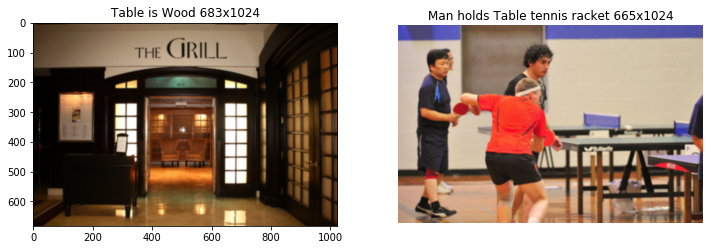

In [7]:
display_list = X_fset_list[0:2]
img_list = []
label_list = []
for f in display_list:
    fid = os.path.basename(f).split('.')[0]
    y = X_dict[fid][0][1]
    label1 = y[0]
    label2 = y[1]
    if label1 in label_dict:
        label1 = label_dict[label1]
    if label2 in label_dict:
        label2 = label_dict[label2]
        
    label_list.append('{} {} {}'.format(label1, y[2], label2))
    img_list.append(cv2.cvtColor(cv2.imread(f, 
                cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB))
show_images(img_list, titles=label_list)

In [8]:
label1_dict, label2_dict, relationship_dict = train_data_label_tuple
print ('Label1 count: {}, Label2 count :{}, Relationship count: {}'.
       format(len(label1_dict), len(label2_dict), len(relationship_dict)))

Label1 count: 32, Label2 count :57, Relationship count: 10


### Exploring the labels of the dataste.

In [10]:
def plot_set_dist(label_dict_input, lookup_dict, y_label, desc, save_name, c1='r'):
    if lookup_dict is None:
        x = list(label_dict_input.keys())
    else:
        x = [ lookup_dict[t] for t in list(label_dict_input.keys()) ]
    y = [ label_dict_input[t] for t in list(label_dict_input.keys()) ]
    x_pos = [i for i, _ in enumerate(x)]
    fig, ax = plt.subplots()
    p1 = ax.barh(x, y, color=c1)
    ax.set_ylabel(y_label)
    ax.set_yticks(x_pos, x)
    ax.set_xlabel("Count")
    ax.set_title(desc)
    fig.set_figheight(15)
    fig.set_figwidth(15)
    plt.show()
    plt.draw()
    fig.savefig("examples/" + save_name + ".png")

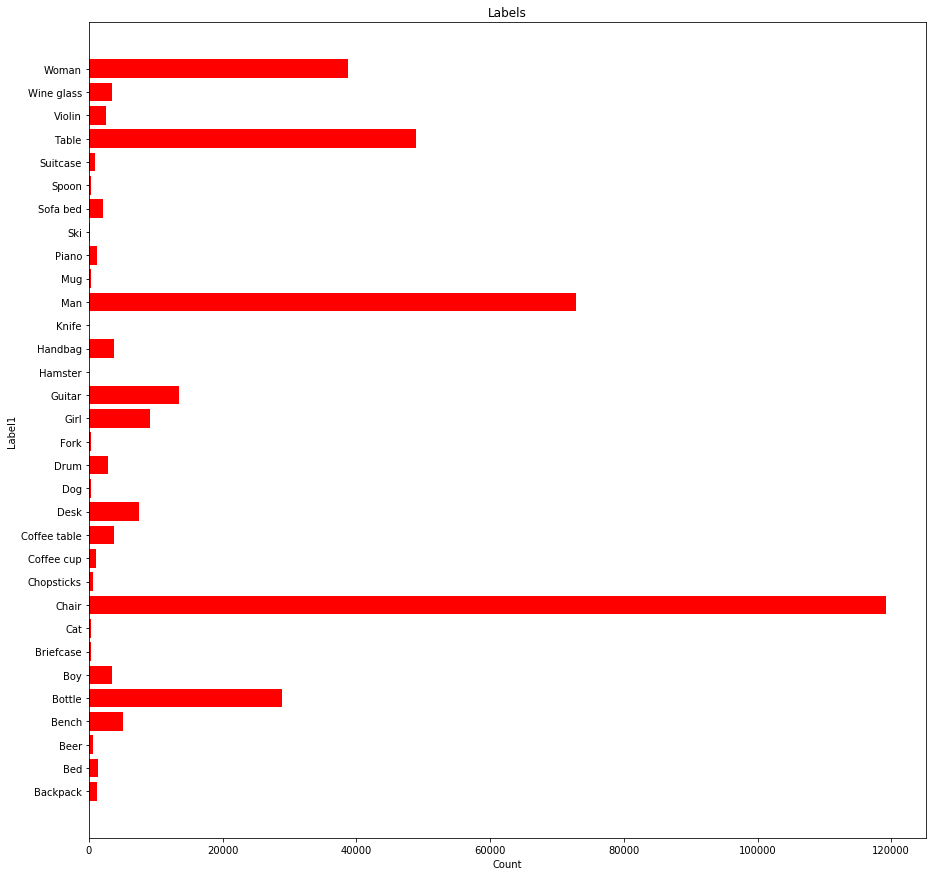

In [11]:
plot_set_dist(label1_dict, label_dict, "Label1", "Labels", "label1_barplot")

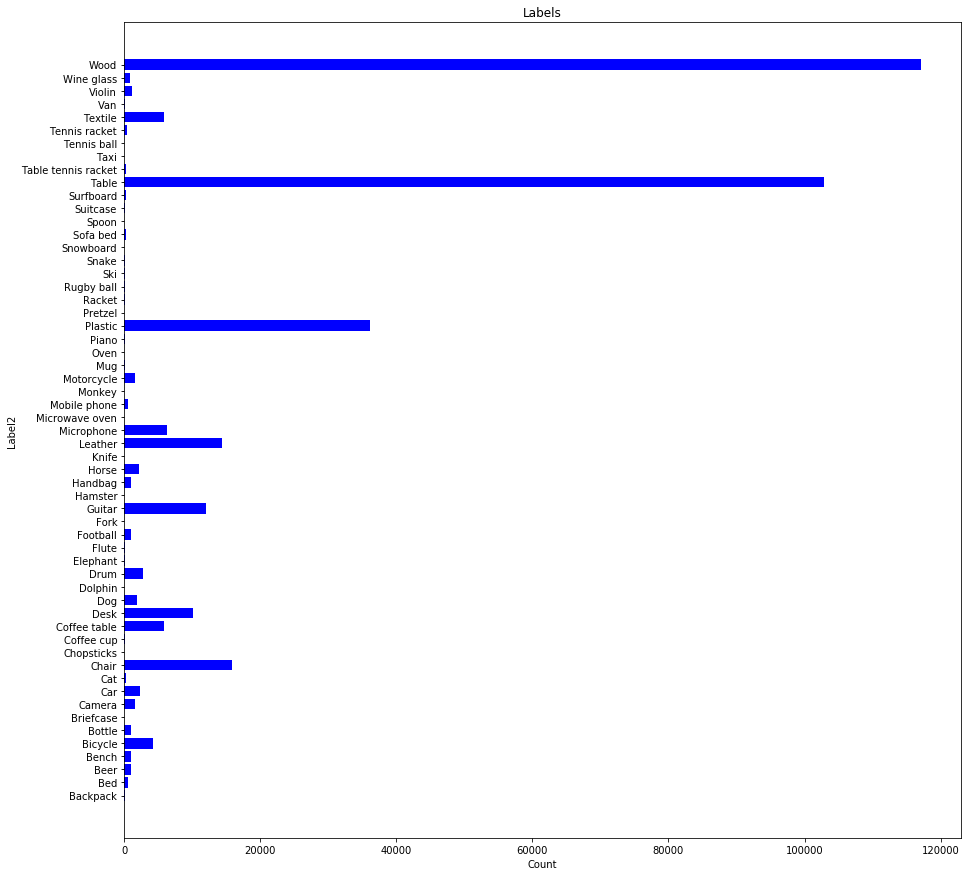

In [12]:
plot_set_dist(label2_dict, label_dict, "Label2", "Labels", "label2_barplot", c1='b')

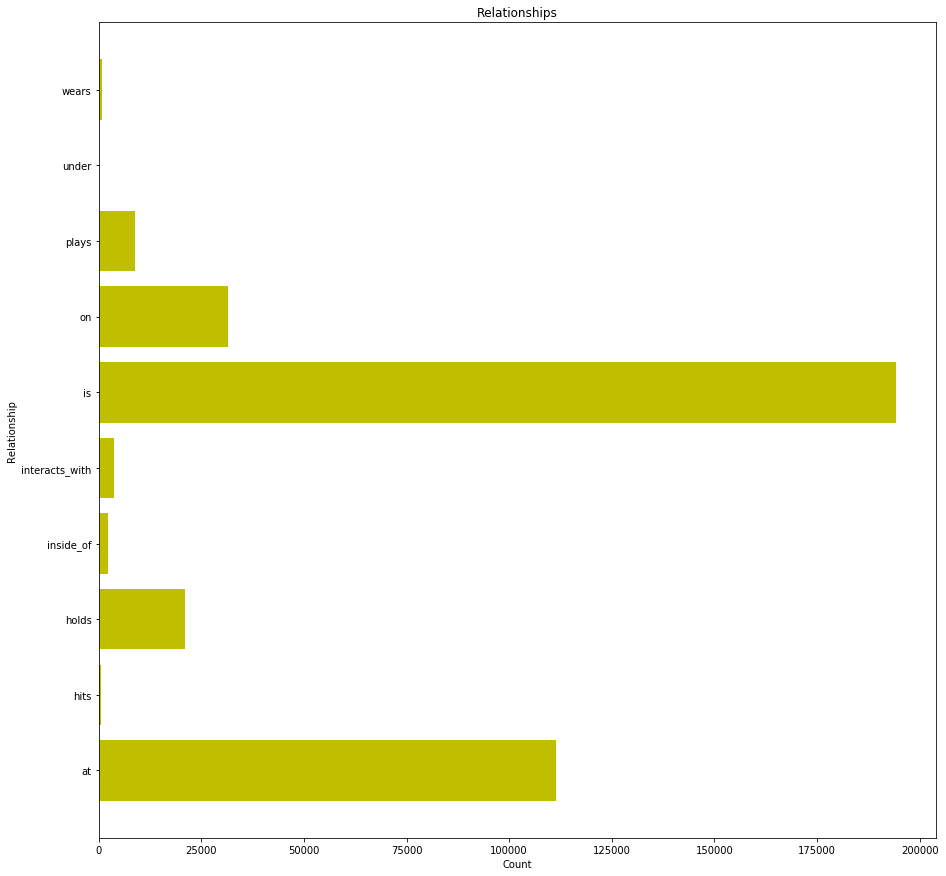

In [13]:
plot_set_dist(relationship_dict, None, "Relationship", "Relationships", "relationship_barplot", c1='y')

### Resize and data prep code
The following few cells help with saving resized images. Had to resize them to 96x96 to avoid out of memory issues. Have to fix these buy bumping up the memory on the box. Currently it only has 32GB. The full sized images are 28GB. Reducing them to 96x96 gets us to 803MB.

In [ ]:
# Resize the data so it can fit in memory all of it.
def resize_all(X_dict, prefix='data/processed', output_dir='resized_images', xsize=96, ysize=96):
    output_dir = os.path.join(prefix, output_dir)
    os.makedirs(output_dir, exist_ok=True)
    X_dict_img = {}
    for k, v in X_dict.items():
        if v[1] is None:
            continue
        try:
            if os.path.isfile(v[1]) is False:
                print('Invalid file failed for {}'.format(v[1]))
                continue
        except:
            print('Invalid file failed for {}'.format(v))
            raise
        out_file = os.path.join(output_dir, os.path.basename(v[1]))
        if os.path.isfile(out_file):
            continue
        try:
            img = cv2.imread(v[1], cv2.IMREAD_COLOR)
            resize_img = cv2.cvtColor(cv2.resize(img,(ysize, xsize)), cv2.COLOR_BGR2RGB)
            out_file = os.path.join(output_dir, os.path.basename(v[1]))
            cv2.imwrite(out_file, resize_img)
            X_dict_img[k] = (v[0], out_file)
        except:
            print('Imread failed for {}'.format(v[1]))
            pass      
    return X_dict_img

In [14]:
# Uncomment if you want to resize the data again
# X_dict_img = resize_all(X_dict)

In [16]:
xy_list, train_data_label_tuple, label_dict = process_raw_csv_input()
X_dict = {}
for xy in xy_list:
    x = xy[0]
    X_dict[x[0]] = (xy, None)
X_fset, X_dict = get_data_from_dir_recursive(X_dict, dir_input='resized_images')

Label2 missing: /m/02gy9n, label1 : Bottle, relation: is
Missing label count: 20644
Processing dir: data/processed/resized_images, image count: 96499


### Load the images and prep for the network.

In [17]:
X_fset_list = list(X_fset)
print ("Size of X_fset: {}".format(len(X_fset)))
print ("Example file: {}".format(X_fset_list[0]))

dataset = {'features': [], 'labels': [], 'labels_orig': []}
for k, v in X_dict.items():
    if v[1] is not None and os.path.isfile(v[1]):
        dataset['features'].append(cv2.cvtColor(cv2.imread(v[1], 
                cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)/255.0)
        dataset['labels_orig'].append(v[0][1])

Size of X_fset: 96499
Example file: data/processed/resized_images/58d6abf3b9867dfd.jpg


### Use Multi Label Binarizer to encode the labels for the images.
Split the data into training and test sets.

In [18]:
print ('Before Multi-Encoding eature shape: {}, label: {}'.format(dataset['features'][0].shape, dataset['labels_orig'][0]))

# Multi-label encoding
mlb = MultiLabelBinarizer()

dataset['labels'] = mlb.fit_transform(dataset['labels_orig'])
print ('After Multi-Encoding eature shape: {}, label: {}'.format(dataset['features'][0].shape, dataset['labels'][0]))
X_train, X_test, y_train, y_test = train_test_split(dataset['features'],
                                                    dataset['labels'],
                                                    test_size=0.20, random_state=42)
print('MLB classes size {}, classes: {}'.format(len(mlb.classes_), mlb.classes_))

Before Multi-Encoding eature shape: (96, 96, 3), label: ('/m/04yx4', '/m/0342h', 'plays')
After Multi-Encoding eature shape: (96, 96, 3), label: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
MLB classes size 70, classes: ['/m/01226z' '/m/01599' '/m/01940j' '/m/0199g' '/m/019w40' '/m/01_5g'
 '/m/01bl7v' '/m/01f91_' '/m/01mzpv' '/m/01s55n' '/m/01y9k5' '/m/01yrx'
 '/m/026t6' '/m/02hj4' '/m/02jvh9' '/m/02p5f1q' '/m/0342h' '/m/03bt1vf'
 '/m/03k3r' '/m/03m3pdh' '/m/03qrc' '/m/03ssj5' '/m/04_sv' '/m/04bcr3'
 '/m/04ctx' '/m/04dr76w' '/m/04lbp' '/m/04yx4' '/m/050k8' '/m/0584n8'
 '/m/05_5p_0' '/m/05ctyq' '/m/05r5c' '/m/05r655' '/m/05z87' '/m/06__v'
 '/m/071p9' '/m/078jl' '/m/078n6m' '/m/07y_7' '/m/080hkjn' '/m/083vt'
 '/m/08pbxl' '/m/09tvcd' '/m/0bt9lr' '/m/0bwd_0j' '/m/0cmx8' '/m/0cvnqh'
 '/m/0dnr7' '/m/0dt3t' '/m/0dv5r' '/m/0dv9c' '/m/0fx9l' '/m/0h2r6'
 '/m/0h8my_4' '/m/0hg7b' '/m/0k4j' '/m/0l14j_'

### A trivial baseline CNN model.
Three layers of convolutions and a fully connected layer and output layer.

In [20]:
def BaseLineModel(input_shape, output_size, pool_layer1=True, pool_layer2_plus=False):
    """
    Model is regular CNN without Pooling for some or all layers
    """
    model = Sequential()
    # Layer 1 Conv with relu, more filters than recommended
    model.add(Conv2D(32, kernel_size=(5, 5), activation='relu', strides=2, padding='valid', 
                     input_shape=input_shape))
    if pool_layer1 is True:
        model.add(MaxPooling2D(pool_size=(2, 2)))
    # Layer 2 Conv with relu, more filters than recommended
    model.add(Conv2D(48, kernel_size=(5, 5), activation='relu', strides=2, padding='valid'))
    if pool_layer2_plus is True:
        model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    # Layer 3 Conv with relu, more filters than recommended
    model.add(Conv2D(64, kernel_size=(5, 5), activation='relu', strides=2, padding='valid'))
    if pool_layer2_plus is True:
        model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    # Layer 4 Flatten for fully connected layers
    model.add(Flatten())
    # Layer 5 Fully connected with 500 Units
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    # Output Layer
    model.add(Dense(output_size, activation='sigmoid'))

    return model

### Loss function and Optimization

We use the **Binary Crossentropy** loss function and **Adam** optimizer. Batch size is set to 64 and number of default epochs are 32.
**We note that more investigation is need to find out a correct loss function and an accuracy measure to help SGD find the optimal weights.**

In [21]:
def train_model(model, x_train, y_train, learn_rate=0.001, epochs=32, batch_size=64, verbose=1):
    """
    Train the model.
    Using as loss function and Adam optimizer, default learning rate is .001
    """
    model.compile(loss='binary_crossentropy', 
        optimizer=keras.optimizers.Adam(lr=learn_rate, decay=learn_rate / epochs), metrics=['accuracy'])
    return model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs,
        verbose=verbose, validation_split=0.2, shuffle=True)

In [22]:
# Get the model
model = BaseLineModel(X_train[0].shape, output_size=len(mlb.classes_))
model.summary()

# Train the model
epochs = 32
model_history = train_model(model, np.array(X_train), np.array(y_train), epochs=epochs)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 46, 46, 32)        2432      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 23, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 48)        38448     
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 10, 48)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 3, 64)          76864     
_________________________________________________________________
dropout_2 (Dropout)          (None, 3, 3, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 576)               0         
__________

### Save the model
Save the model that has been trained.

In [23]:
# Save the weights.
model.save_weights('model_weights.h5')

# Save the model architecture.
with open('model_architecture.json', 'w') as f:
    f.write(model.to_json())
    
# Save the MLB labels for later use.
with open("mlb_labels.p", "wb") as f:
    f.write(pickle.dumps(mlb))

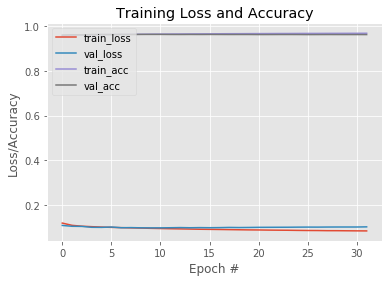

In [24]:
# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, epochs), model_history.history["loss"], label="train_loss")
plt.plot(np.arange(0, epochs), model_history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, epochs), model_history.history["acc"], label="train_acc")
plt.plot(np.arange(0, epochs), model_history.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper left")
plt.savefig("model_training_plot.png")

### Invalid accuracy score of test set.
Due to multi-label classification problem the accuracy is artificially high due the fact that many labels are correctly classified as False.

In [25]:
# evaluate the model
scores = model.evaluate(np.array(X_test), np.array(y_test))
print('\n{}: {}'.format(model.metrics_names[1], scores[1]*100))

19136/19300 [============================>.] - ETA: 0s
acc: 96.16389764281752


In [35]:
pred = model.predict(np.expand_dims(X_train[0], axis=0))
print('Pred : {}'.format((pred * 100).flatten().tolist()))
print('Truth: {}'.format(y_train[0].flatten().tolist()))

def check_pred(pred, ground):
    pred = pred.flatten().tolist()
    ground = ground.flatten().tolist()
    max_check = float('-inf')
    
    # Get the maximum in pred not corresponding to
    # categories set to true in ground.
    l = [] # Save the ground indices where True exists.
    for i in range(0, len(ground)):
        if ground[i] == 0:
            max_check = max(max_check, pred[i])
        else:
            l.append(i)
    
    # Check that all other elements that do not
    # correspond to prediction do not exceed the minumum above.
    count = 0
    for i in l:
        if max_check < pred[i]:
            count +=1
    
    # Did we get all, if not how many?.
    return count == len(l), count

print ('check_pred: {}'.format(check_pred(pred, y_train[0])))

Pred : [18.684282302856445, 0.09469042718410492, 0.18132318556308746, 2.153609037399292, 0.009746991097927094, 0.00012734979100059718, 8.96229076385498, 0.00010708619083743542, 2.552551031112671, 0.006542949937283993, 0.012831542640924454, 0.06400768458843231, 0.5997057557106018, 6.812732317484915e-05, 0.0003645478282123804, 0.017229929566383362, 0.41556814312934875, 27.962993621826172, 11.431406021118164, 0.002429138869047165, 0.005850717891007662, 0.00313799106515944, 0.5011672377586365, 5.8310112953186035, 2.7428109206084628e-06, 0.1711556613445282, 0.06408233195543289, 53.376949310302734, 0.1307145208120346, 3.5907243045585346e-07, 0.005302833393216133, 0.0026053430046886206, 0.0011770896380767226, 11.831656455993652, 0.3373773396015167, 0.011628445237874985, 0.017323562875390053, 0.04771003499627113, 0.010293148458003998, 0.06827133148908615, 0.36666303873062134, 1.6495330333709717, 0.01431328896433115, 0.04176851361989975, 25.15492820739746, 0.40824589133262634, 0.001223019906319

### Test set error calculation
Iterate through every test set example get the prediction using the model and check with the available label.

In [42]:
def accuracy_calc_helper(feature_set, label_set):
    accurate_prediction_count_dict = {0: [], 1: [], 2: [], 3:[]}
    for i in range(0, len(feature_set)):
        pred = model.predict(np.expand_dims(feature_set[i], axis=0))
        success, success_count = check_pred(pred, label_set[i])
        if success:
            assert success_count == 3
        accurate_prediction_count_dict[success_count].append((i, pred))

    acc_percentages = {}
    for k, v in accurate_prediction_count_dict.items():
        acc_percentages[k] = str(round(len(v)*100.0/len(feature_set), 2))+'%'
        
    return accurate_prediction_count, acc_percentages

accurate_prediction_count, acc_percentages = accuracy_calc_helper(X_test, y_test)

print('Total Test samples: {}, Accuracy percentage map: {}'.format(len(X_test), acc_percentages))

Total Test samples: 19300, Accuracy percentage map: {0: '40.3%', 1: '21.46%', 2: '19.96%', 3: '18.28%'}


### Train set error calculation
Let us check if network is actually working for the training set.
We showcase here the pitfall of loss function used in training which gives a wrong idea of accuracy at training time.

In [44]:
accurate_prediction_count, acc_percentages = accuracy_calc_helper(X_train, y_train)
print('Total Train samples: {}, Accuracy percentage map: {}'.format(len(X_train), acc_percentages))

Total Train samples: 77199, Accuracy percentage map: {0: '24.64%', 1: '21.43%', 2: '26.22%', 3: '27.7%'}


### Summary

Things to do.

1. Investigate a better loss function and different network architectures. 
2. Incorporate advances in semantic segmentation networks by using the bounding box data. 
3. Investigate which pre trained network to use to help with object detection part of the network.
4. Investigate the feasibility of mining language data.